<a href="https://colab.research.google.com/github/CaptainLight5/Emotion-Prediction/blob/main/Roberta_and_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
train_data = pd.read_csv('/content/WASSA23_essay_level_with_labels_train.tsv', sep='\t')
dev_data = pd.read_csv('/content/WASSA23_essay_level_dev.tsv', sep='\t')
test_data = pd.read_csv('/content/WASSA23_essay_level_test.tsv', sep='\t')
goldstandard_dev = pd.read_csv('/content/goldstandard_dev.tsv', sep='\t')


       conversation_id  article_id     empathy    distress  speaker_id  \
count       792.000000  792.000000  792.000000  792.000000  792.000000   
mean        257.669192  187.744949    4.239899    3.782513   28.968434   
std         141.438695  125.756364    2.014705    2.053606   15.026660   
min           2.000000    3.000000    1.000000    1.000000    0.000000   
25%         139.750000   71.000000    2.333333    1.750000   19.000000   
50%         260.500000  171.000000    4.666667    3.875000   25.000000   
75%         375.500000  301.000000    6.000000    6.000000   43.000000   
max         500.000000  417.000000    7.000000    7.000000   58.000000   

       speaker_number    essay_id  
count      792.000000  792.000000  
mean         1.500000  506.669192  
std          0.500316  287.374178  
min          1.000000    1.000000  
25%          1.000000  259.750000  
50%          1.500000  500.000000  
75%          2.000000  759.250000  
max          2.000000  999.000000  
Axes(0.12

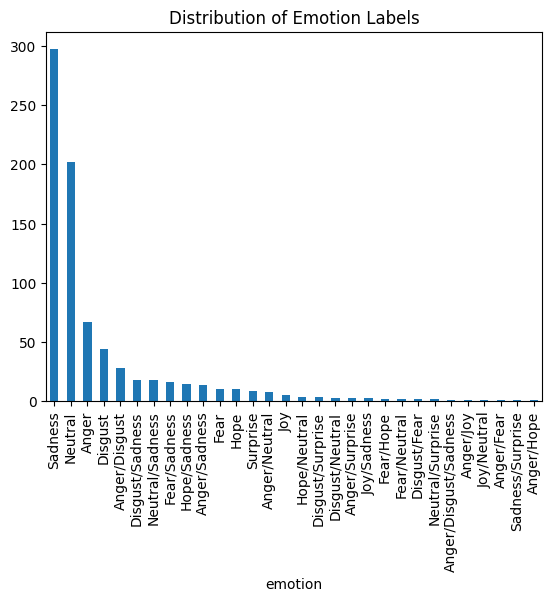

In [11]:
# EDA 1: Summary statistics and distribution of target labels
print(train_data.describe())
print(train_data['emotion'].value_counts().plot(kind='bar', title='Distribution of Emotion Labels'))


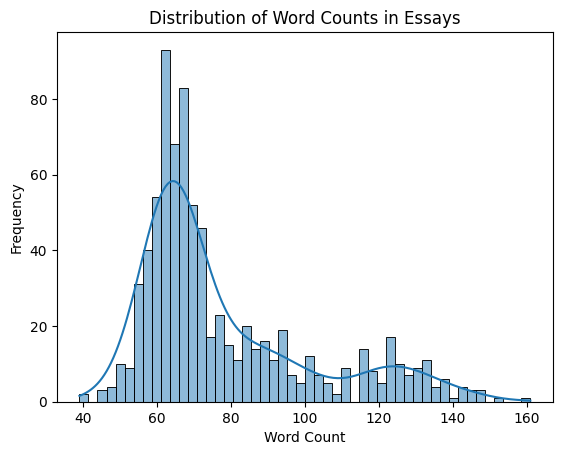

In [12]:

# EDA 2: Word count distribution
train_data['word_count'] = train_data['essay'].apply(lambda x: len(x.split()))
sns.histplot(train_data['word_count'], bins=50, kde=True)
plt.title('Distribution of Word Counts in Essays')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

In [14]:
# EDA 3: Most common words in the dataset
from collections import Counter
all_words = ' '.join(train_data['essay']).split()
common_words = [word for word, count in Counter(all_words).most_common(20)]
print("Most common words in the dataset:", common_words)

Most common words in the dataset: ['the', 'to', 'and', 'I', 'that', 'is', 'a', 'of', 'in', 'are', 'for', 'this', 'it', 'be', 'people', 'they', 'have', 'just', 'was', 'so']


In [15]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import re

# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')

# Data cleaning function
def clean_text(text):
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    return text

# Apply cleaning
train_data['clean_essay'] = train_data['essay'].apply(clean_text)

# Tokenization and stopword removal
stop_words = set(stopwords.words('english'))
train_data['tokens'] = train_data['clean_essay'].apply(lambda x: [word for word in word_tokenize(x) if word not in stop_words])

# Split the data
X_train, X_val, y_train, y_val = train_test_split(train_data['clean_essay'], train_data['emotion'], test_size=0.2, random_state=42)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim.downloader as api

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# Word2Vec Embeddings
word2vec_model = api.load("glove-wiki-gigaword-100")
def get_word2vec_embeddings(text):
    tokens = word_tokenize(text)
    embeddings = [word2vec_model[word] for word in tokens if word in word2vec_model]
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(100)

X_train_w2v = np.array([get_word2vec_embeddings(text) for text in X_train])
X_val_w2v = np.array([get_word2vec_embeddings(text) for text in X_val])


[==================================================] 100.0% 128.1/128.1MB downloaded


In [17]:
from sklearn.feature_selection import SelectKBest, f_classif

# Feature selection using ANOVA F-test for the TF-IDF features
selector = SelectKBest(f_classif, k=3000)
X_train_tfidf_selected = selector.fit_transform(X_train_tfidf, y_train)
X_val_tfidf_selected = selector.transform(X_val_tfidf)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


In [24]:
from transformers import BertTokenizer, BertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader

# Prepare dataset for transformers
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.texts[item]
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length', # Ensure all sequences are padded to the same length
            truncation=True, # Truncate sequences longer than max_length
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Tokenizers and encoders
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Fit LabelEncoder on all unique labels
label_encoder = LabelEncoder()
all_labels = pd.concat([y_train, y_val]).unique() # Get all unique labels from both train and validation sets
label_encoder.fit(all_labels) # Fit the encoder on all labels

y_train_encoded = label_encoder.transform(y_train)
y_val_encoded = label_encoder.transform(y_val)


In [25]:
# Create dataset objects for BERT
train_dataset_bert = EmotionDataset(X_train.tolist(), y_train_encoded, bert_tokenizer, max_len=128)
val_dataset_bert = EmotionDataset(X_val.tolist(), y_val_encoded, bert_tokenizer, max_len=128)

# DataLoader for BERT
train_loader_bert = DataLoader(train_dataset_bert, batch_size=16, shuffle=True)
val_loader_bert = DataLoader(val_dataset_bert, batch_size=16)

In [26]:
# Define BERT model
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Training arguments for BERT
training_args_bert = TrainingArguments(
    output_dir='./results_bert',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_bert',
    logging_steps=10,
)

# Function to compute metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Trainer for BERT
trainer_bert = Trainer(
    model=bert_model,
    args=training_args_bert,
    train_dataset=train_dataset_bert,
    eval_dataset=val_dataset_bert,
    compute_metrics=compute_metrics
)

# Train BERT model
trainer_bert.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,3.581000
20,3.487100
30,3.263000
40,3.068100
50,3.040200
60,3.000000
70,2.784800
80,2.746900
90,2.573500
100,2.475300


TrainOutput(global_step=120, training_loss=2.8731327692667645, metrics={'train_runtime': 2807.1637, 'train_samples_per_second': 0.676, 'train_steps_per_second': 0.043, 'total_flos': 124943376489984.0, 'train_loss': 2.8731327692667645, 'epoch': 3.0})

In [30]:
from transformers import BertTokenizer, BertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Function to compute metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Evaluate BERT model
results_bert = trainer_bert.evaluate()
print("BERT Results:", results_bert)


BERT Results: {'eval_loss': 2.1606054306030273, 'eval_accuracy': 0.4339622641509434, 'eval_f1': 0.2940258159369541, 'eval_precision': 0.3383458646616541, 'eval_recall': 0.4339622641509434, 'eval_runtime': 77.7573, 'eval_samples_per_second': 2.045, 'eval_steps_per_second': 0.129, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
# Create dataset objects for RoBERTa
train_dataset_roberta = EmotionDataset(X_train.tolist(), y_train_encoded, roberta_tokenizer, max_len=128)
val_dataset_roberta = EmotionDataset(X_val.tolist(), y_val_encoded, roberta_tokenizer, max_len=128)

# DataLoader for RoBERTa
train_loader_roberta = DataLoader(train_dataset_roberta, batch_size=16, shuffle=True)
val_loader_roberta = DataLoader(val_dataset_roberta, batch_size=16)


In [34]:
from transformers import BertTokenizer, BertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Define RoBERTa model
roberta_model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(label_encoder.classes_))

# Training arguments for RoBERTa
training_args_roberta = TrainingArguments(
    output_dir='./results_roberta',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_roberta',
    logging_steps=10,
)

# Function to compute metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }



# Trainer for RoBERTa
trainer_roberta = Trainer(
    model=roberta_model,
    args=training_args_roberta,
    train_dataset=train_dataset_roberta,
    eval_dataset=val_dataset_roberta,
    compute_metrics=compute_metrics
)

# Train RoBERTa model
trainer_roberta.train()

# Evaluate RoBERTa model
results_roberta = trainer_roberta.evaluate()
print("RoBERTa Results:", results_roberta)



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,3.358000
20,3.321400
30,3.309300
40,3.264800
50,3.146900
60,2.814900
70,2.343800
80,2.354300
90,2.211500
100,2.169600


Step,Training Loss
10,3.358000
20,3.321400
30,3.309300
40,3.264800
50,3.146900
60,2.814900
70,2.343800
80,2.354300
90,2.211500
100,2.169600


RoBERTa Results: {'eval_loss': 1.6373709440231323, 'eval_accuracy': 0.5849056603773585, 'eval_f1': 0.49385375638688533, 'eval_precision': 0.43056063246889764, 'eval_recall': 0.5849056603773585, 'eval_runtime': 68.6014, 'eval_samples_per_second': 2.318, 'eval_steps_per_second': 0.146, 'epoch': 5.0}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


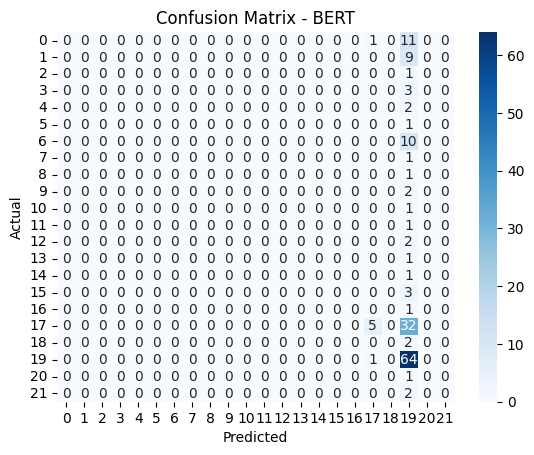

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


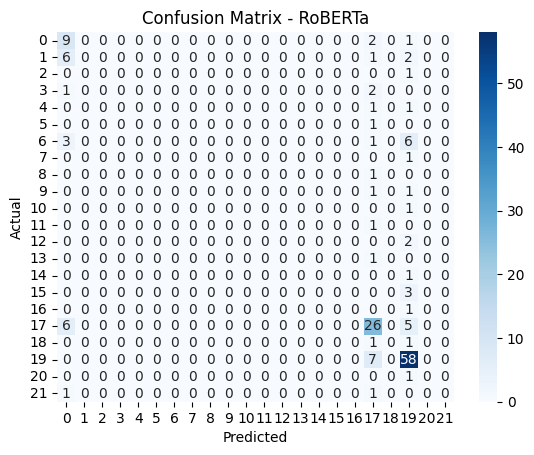

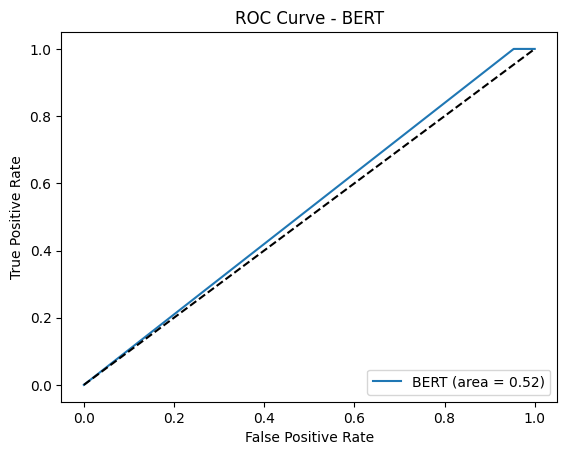

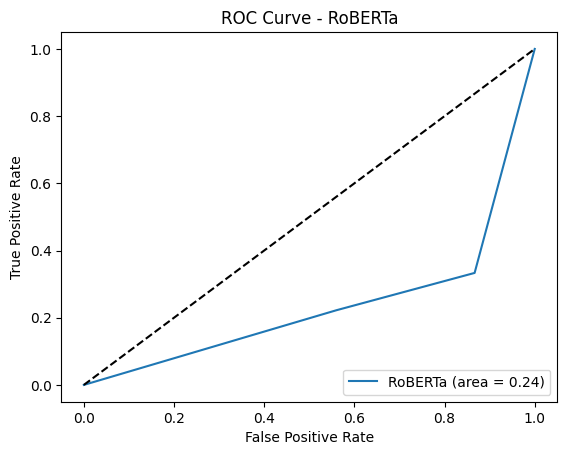

In [35]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc

# Confusion Matrix for BERT
preds_bert = trainer_bert.predict(val_dataset_bert)
cm_bert = confusion_matrix(preds_bert.label_ids, preds_bert.predictions.argmax(-1))
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - BERT')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Confusion Matrix for RoBERTa
preds_roberta = trainer_roberta.predict(val_dataset_roberta)
cm_roberta = confusion_matrix(preds_roberta.label_ids, preds_roberta.predictions.argmax(-1))
sns.heatmap(cm_roberta, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - RoBERTa')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve for BERT
fpr_bert, tpr_bert, _ = roc_curve(preds_bert.label_ids, preds_bert.predictions.argmax(-1), pos_label=1)
roc_auc_bert = auc(fpr_bert, tpr_bert)
plt.plot(fpr_bert, tpr_bert, label=f'BERT (area = {roc_auc_bert:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - BERT')
plt.legend(loc='lower right')
plt.show()

# ROC Curve for RoBERTa
fpr_roberta, tpr_roberta, _ = roc_curve(preds_roberta.label_ids, preds_roberta.predictions.argmax(-1), pos_label=1)
roc_auc_roberta = auc(fpr_roberta, tpr_roberta)
plt.plot(fpr_roberta, tpr_roberta, label=f'RoBERTa (area = {roc_auc_roberta:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RoBERTa')
plt.legend(loc='lower right')
plt.show()
